# Regression Analysis: Predicting Profitability

## Import Packages and Load Data

In [1]:
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
import sweetviz as sv

pd.set_option('display.max_columns', None)

In [2]:
orders_data = pd.read_excel('../data/(US) Sample - Superstore.xlsx', sheet_name='Orders')
people_data = pd.read_excel('../data/(US) Sample - Superstore.xlsx', sheet_name='People')
returns_data = pd.read_excel('../data/(US) Sample - Superstore.xlsx', sheet_name='Returns')

In [3]:
returns_data = returns_data.drop_duplicates(subset = ['Order ID'], ignore_index=True)
returns_data

,Returned,Order ID
0,Yes,CA-2019-100762
1,Yes,CA-2019-100867
2,Yes,CA-2019-102652
3,Yes,CA-2019-103373
4,Yes,CA-2019-103744
...,...,...
291,Yes,US-2022-136679
292,Yes,US-2022-147886
293,Yes,US-2022-147998
294,Yes,US-2022-151127


#### Merge DataFrames

In [4]:
full_data = pd.merge(orders_data, people_data, on='Region', how='left')
full_data

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Regional Manager
0,1,CA-2021-152156,2021-11-08,2021-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,Fred Suzuki
1,2,CA-2021-152156,2021-11-08,2021-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,Fred Suzuki
2,3,CA-2021-138688,2021-06-12,2021-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,Sadie Pawthorne
3,4,US-2020-108966,2020-10-11,2020-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,Fred Suzuki
4,5,US-2020-108966,2020-10-11,2020-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,Fred Suzuki
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,CA-2019-110422,2019-01-21,2019-01-23,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,Florida,33180.0,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028,Fred Suzuki
9990,9991,CA-2022-121258,2022-02-26,2022-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,92627.0,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332,Sadie Pawthorne
9991,9992,CA-2022-121258,2022-02-26,2022-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,92627.0,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932,Sadie Pawthorne
9992,9993,CA-2022-121258,2022-02-26,2022-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,92627.0,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,13.3200,Sadie Pawthorne


In [5]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Row ID            9994 non-null   int64         
 1   Order ID          9994 non-null   object        
 2   Order Date        9994 non-null   datetime64[ns]
 3   Ship Date         9994 non-null   datetime64[ns]
 4   Ship Mode         9994 non-null   object        
 5   Customer ID       9994 non-null   object        
 6   Customer Name     9994 non-null   object        
 7   Segment           9994 non-null   object        
 8   Country/Region    9994 non-null   object        
 9   City              9994 non-null   object        
 10  State             9994 non-null   object        
 11  Postal Code       9983 non-null   float64       
 12  Region            9994 non-null   object        
 13  Product ID        9994 non-null   object        
 14  Category          9994 n

In [6]:
returns_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Returned  296 non-null    object
 1   Order ID  296 non-null    object
dtypes: object(2)
memory usage: 4.8+ KB


In [7]:
full_data = pd.merge(full_data, returns_data, on='Order ID', how='left')
full_data

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Regional Manager,Returned
0,1,CA-2021-152156,2021-11-08,2021-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,Fred Suzuki,NaN
1,2,CA-2021-152156,2021-11-08,2021-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,Fred Suzuki,NaN
2,3,CA-2021-138688,2021-06-12,2021-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,Sadie Pawthorne,NaN
3,4,US-2020-108966,2020-10-11,2020-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,Fred Suzuki,NaN
4,5,US-2020-108966,2020-10-11,2020-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,Fred Suzuki,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,CA-2019-110422,2019-01-21,2019-01-23,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,Florida,33180.0,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028,Fred Suzuki,NaN
9990,9991,CA-2022-121258,2022-02-26,2022-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,92627.0,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332,Sadie Pawthorne,Yes
9991,9992,CA-2022-121258,2022-02-26,2022-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,92627.0,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932,Sadie Pawthorne,Yes
9992,9993,CA-2022-121258,2022-02-26,2022-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,92627.0,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,13.3200,Sadie Pawthorne,Yes


## Inspect and Fill Missing Values

In [8]:
full_data.isna().sum()

Row ID                 0
Order ID               0
Order Date             0
Ship Date              0
Ship Mode              0
Customer ID            0
Customer Name          0
Segment                0
Country/Region         0
City                   0
State                  0
Postal Code           11
Region                 0
Product ID             0
Category               0
Sub-Category           0
Product Name           0
Sales                  0
Quantity               0
Discount               0
Profit                 0
Regional Manager       0
Returned            9194
dtype: int64

In [9]:
full_data.loc[:, 'Returned'] = full_data.loc[:, 'Returned'].fillna('No')
full_data.isna().sum()

Row ID               0
Order ID             0
Order Date           0
Ship Date            0
Ship Mode            0
Customer ID          0
Customer Name        0
Segment              0
Country/Region       0
City                 0
State                0
Postal Code         11
Region               0
Product ID           0
Category             0
Sub-Category         0
Product Name         0
Sales                0
Quantity             0
Discount             0
Profit               0
Regional Manager     0
Returned             0
dtype: int64

In [10]:
full_data.loc[:, 'Returned']  = (full_data.loc[:, 'Returned']
                                 .str.replace('Yes', '1')
                                 .str.replace('No', '0'))
full_data['Returned'] = full_data['Returned'].astype(int)
full_data.loc[:, 'Returned'] 

0       0
1       0
2       0
3       0
4       0
       ..
9989    0
9990    1
9991    1
9992    1
9993    0
Name: Returned, Length: 9994, dtype: int32

In [11]:
full_data[full_data['Postal Code'].isna()]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Regional Manager,Returned
2234,2235,CA-2022-104066,2022-12-05,2022-12-10,Standard Class,QJ-19255,Quincy Jones,Corporate,United States,Burlington,Vermont,NaN,East,TEC-AC-10001013,Technology,Accessories,Logitech ClearChat Comfort/USB Headset H390,205.03,7,0.0,67.6599,Chuck Magee,0
5274,5275,CA-2020-162887,2020-11-07,2020-11-09,Second Class,SV-20785,Stewart Visinsky,Consumer,United States,Burlington,Vermont,NaN,East,FUR-CH-10000595,Furniture,Chairs,Safco Contoured Stacking Chairs,715.20,3,0.0,178.8000,Chuck Magee,0
8798,8799,US-2021-150140,2021-04-06,2021-04-10,Standard Class,VM-21685,Valerie Mitchum,Home Office,United States,Burlington,Vermont,NaN,East,TEC-PH-10002555,Technology,Phones,Nortel Meridian M5316 Digital phone,1294.75,5,0.0,336.6350,Chuck Magee,0
9146,9147,US-2021-165505,2021-01-23,2021-01-27,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,TEC-AC-10002926,Technology,Accessories,Logitech Wireless Marathon Mouse M705,99.98,2,0.0,42.9914,Chuck Magee,0
9147,9148,US-2021-165505,2021-01-23,2021-01-27,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-AR-10003477,Office Supplies,Art,4009 Highlighters,8.04,6,0.0,2.7336,Chuck Magee,0
9148,9149,US-2021-165505,2021-01-23,2021-01-27,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-ST-10001526,Office Supplies,Storage,Iceberg Mobile Mega Data/Printer Cart,1564.29,13,0.0,406.7154,Chuck Magee,0
9386,9387,US-2022-127292,2022-01-19,2022-01-23,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10000157,Office Supplies,Paper,Xerox 191,79.92,4,0.0,37.5624,Chuck Magee,0
9387,9388,US-2022-127292,2022-01-19,2022-01-23,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,12.28,1,0.0,5.7716,Chuck Magee,0
9388,9389,US-2022-127292,2022-01-19,2022-01-23,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-AP-10000828,Office Supplies,Appliances,Avanti 4.4 Cu. Ft. Refrigerator,542.94,3,0.0,152.0232,Chuck Magee,0
9389,9390,US-2022-127292,2022-01-19,2022-01-23,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-EN-10001509,Office Supplies,Envelopes,Poly String Tie Envelopes,2.04,1,0.0,0.9588,Chuck Magee,0


In [12]:
## See if any other orders have the same city and state
missing_city = full_data['City'] == 'Burlington'
missing_state = full_data['State'] == 'Vermont'

full_data.loc[missing_city & missing_state, 'Postal Code']

2234   NaN
5274   NaN
8798   NaN
9146   NaN
9147   NaN
9148   NaN
9386   NaN
9387   NaN
9388   NaN
9389   NaN
9741   NaN
Name: Postal Code, dtype: float64

In [13]:
## Filling missing values for Postal Code for Burlington, VT
## Using one of several zip codes for Burlington, VT

full_data.loc[:, 'Postal Code'] = full_data['Postal Code'].fillna("05401")
full_data.isna().sum()

C:\Users\Ben\AppData\Local\Temp\ipykernel_11288\112436129.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[42420.0 42420.0 90036.0 ... 92627.0 92627.0 92683.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  full_data.loc[:, 'Postal Code'] = full_data['Postal Code'].fillna("05401")


Row ID              0
Order ID            0
Order Date          0
Ship Date           0
Ship Mode           0
Customer ID         0
Customer Name       0
Segment             0
Country/Region      0
City                0
State               0
Postal Code         0
Region              0
Product ID          0
Category            0
Sub-Category        0
Product Name        0
Sales               0
Quantity            0
Discount            0
Profit              0
Regional Manager    0
Returned            0
dtype: int64

In [14]:
full_data.loc[:, 'Postal Code'].dtype

dtype('O')

In [15]:
full_data['Postal Code'] = pd.to_numeric(full_data['Postal Code'], downcast='integer')
full_data['Postal Code']

0       42420
1       42420
2       90036
3       33311
4       33311
        ...  
9989    33180
9990    92627
9991    92627
9992    92627
9993    92683
Name: Postal Code, Length: 9994, dtype: int32

In [16]:
full_data['Postal Code'] = full_data['Postal Code'].astype('object')
full_data.loc[:, 'Postal Code']

0       42420
1       42420
2       90036
3       33311
4       33311
        ...  
9989    33180
9990    92627
9991    92627
9992    92627
9993    92683
Name: Postal Code, Length: 9994, dtype: object

## Calculate Cost of Order

In [17]:
full_data['Order Cost'] = full_data['Sales'] - full_data['Profit']
full_data

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Regional Manager,Returned,Order Cost
0,1,CA-2021-152156,2021-11-08,2021-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,Fred Suzuki,0,220.0464
1,2,CA-2021-152156,2021-11-08,2021-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,Fred Suzuki,0,512.3580
2,3,CA-2021-138688,2021-06-12,2021-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,Sadie Pawthorne,0,7.7486
3,4,US-2020-108966,2020-10-11,2020-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,Fred Suzuki,0,1340.6085
4,5,US-2020-108966,2020-10-11,2020-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,Fred Suzuki,0,19.8516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,CA-2019-110422,2019-01-21,2019-01-23,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,Florida,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028,Fred Suzuki,0,21.1452
9990,9991,CA-2022-121258,2022-02-26,2022-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,92627,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332,Sadie Pawthorne,1,76.3268
9991,9992,CA-2022-121258,2022-02-26,2022-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,92627,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932,Sadie Pawthorne,1,239.1828
9992,9993,CA-2022-121258,2022-02-26,2022-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,13.3200,Sadie Pawthorne,1,16.2800


## Create Date-Related Features

In [18]:
## Convert Order Date and Ship Date to new columns

## Ensure that the Order Date and Ship Date are in datetime format
full_data['Order Date'] = pd.to_datetime(full_data['Order Date'])
full_data['Ship Date'] = pd.to_datetime(full_data['Ship Date'])

## Generate Order Date features
full_data['Order_Quarter'] = full_data['Order Date'].dt.quarter.astype(int)
full_data['Order_WeekOfYear'] = full_data['Order Date'].dt.isocalendar().week.astype(int)
full_data['Order_WeekOfMonth'] = full_data['Order Date'].apply(lambda x: (x.day - 1) // 7 + 1).astype(int)
full_data['Order_DayOfYear'] = full_data['Order Date'].dt.dayofyear.astype(int)
full_data['Order_DayOfMonth'] = full_data['Order Date'].dt.day.astype(int)
full_data['Order_DayOfWeek'] = full_data['Order Date'].dt.dayofweek.astype(int)

## Generate Ship Date features
full_data['Ship_Quarter'] = full_data['Ship Date'].dt.quarter.astype(int)
full_data['Ship_WeekOfYear'] = full_data['Ship Date'].dt.isocalendar().week.astype(int)
full_data['Ship_WeekOfMonth'] = full_data['Ship Date'].apply(lambda x: (x.day - 1) // 7 + 1).astype(int)
full_data['Ship_DayOfYear'] = full_data['Ship Date'].dt.dayofyear.astype(int)
full_data['Ship_DayOfMonth'] = full_data['Ship Date'].dt.day.astype(int)
full_data['Ship_DayOfWeek'] = full_data['Ship Date'].dt.dayofweek.astype(int)

full_data

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Regional Manager,Returned,Order Cost,Order_Quarter,Order_WeekOfYear,Order_WeekOfMonth,Order_DayOfYear,Order_DayOfMonth,Order_DayOfWeek,Ship_Quarter,Ship_WeekOfYear,Ship_WeekOfMonth,Ship_DayOfYear,Ship_DayOfMonth,Ship_DayOfWeek
0,1,CA-2021-152156,2021-11-08,2021-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,Fred Suzuki,0,220.0464,4,45,2,312,8,0,4,45,2,315,11,3
1,2,CA-2021-152156,2021-11-08,2021-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,Fred Suzuki,0,512.3580,4,45,2,312,8,0,4,45,2,315,11,3
2,3,CA-2021-138688,2021-06-12,2021-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,Sadie Pawthorne,0,7.7486,2,23,2,163,12,5,2,24,3,167,16,2
3,4,US-2020-108966,2020-10-11,2020-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,Fred Suzuki,0,1340.6085,4,41,2,285,11,6,4,42,3,292,18,6
4,5,US-2020-108966,2020-10-11,2020-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,Fred Suzuki,0,19.8516,4,41,2,285,11,6,4,42,3,292,18,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,CA-2019-110422,2019-01-21,2019-01-23,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,Florida,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028,Fred Suzuki,0,21.1452,1,4,3,21,21,0,1,4,4,23,23,2
9990,9991,CA-2022-121258,2022-02-26,2022-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,92627,West,FUR-FU-10000747,Furniture,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332,Sadie Pawthorne,1,76.3268,1,8,4,57,26,5,1,9,1,62,3,3
9991,9992,CA-2022-121258,2022-02-26,2022-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,92627,West,TEC-PH-10003645,Technology,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932,Sadie Pawthorne,1,239.1828,1,8,4,57,26,5,1,9,1,62,3,3
9992,9993,CA-2022-121258,2022-02-26,2022-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,California,92627,West,OFF-PA-10004041,Office Supplies,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,13.3200,Sadie Pawthorne,1,16.2800,1,8,4,57,26,5,1,9,1,62,3,3


## Drop Unnecessary Columns

In [19]:
full_data = full_data.drop(columns = ['Row ID', 'Order Date', 'Ship Date',
                                      'Order ID', 'Customer Name', 'Product Name'])
full_data

,Ship Mode,Customer ID,Segment,Country/Region,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Sales,Quantity,Discount,Profit,Regional Manager,Returned,Order Cost,Order_Quarter,Order_WeekOfYear,Order_WeekOfMonth,Order_DayOfYear,Order_DayOfMonth,Order_DayOfWeek,Ship_Quarter,Ship_WeekOfYear,Ship_WeekOfMonth,Ship_DayOfYear,Ship_DayOfMonth,Ship_DayOfWeek
0,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,261.9600,2,0.00,41.9136,Fred Suzuki,0,220.0464,4,45,2,312,8,0,4,45,2,315,11,3
1,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,731.9400,3,0.00,219.5820,Fred Suzuki,0,512.3580,4,45,2,312,8,0,4,45,2,315,11,3
2,Second Class,DV-13045,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,14.6200,2,0.00,6.8714,Sadie Pawthorne,0,7.7486,2,23,2,163,12,5,2,24,3,167,16,2
3,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,957.5775,5,0.45,-383.0310,Fred Suzuki,0,1340.6085,4,41,2,285,11,6,4,42,3,292,18,6
4,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,22.3680,2,0.20,2.5164,Fred Suzuki,0,19.8516,4,41,2,285,11,6,4,42,3,292,18,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,Second Class,TB-21400,Consumer,United States,Miami,Florida,33180,South,FUR-FU-10001889,Furniture,Furnishings,25.2480,3,0.20,4.1028,Fred Suzuki,0,21.1452,1,4,3,21,21,0,1,4,4,23,23,2
9990,Standard Class,DB-13060,Consumer,United States,Costa Mesa,California,92627,West,FUR-FU-10000747,Furniture,Furnishings,91.9600,2,0.00,15.6332,Sadie Pawthorne,1,76.3268,1,8,4,57,26,5,1,9,1,62,3,3
9991,Standard Class,DB-13060,Consumer,United States,Costa Mesa,California,92627,West,TEC-PH-10003645,Technology,Phones,258.5760,2,0.20,19.3932,Sadie Pawthorne,1,239.1828,1,8,4,57,26,5,1,9,1,62,3,3
9992,Standard Class,DB-13060,Consumer,United States,Costa Mesa,California,92627,West,OFF-PA-10004041,Office Supplies,Paper,29.6000,4,0.00,13.3200,Sadie Pawthorne,1,16.2800,1,8,4,57,26,5,1,9,1,62,3,3


In [20]:
full_data

,Ship Mode,Customer ID,Segment,Country/Region,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Sales,Quantity,Discount,Profit,Regional Manager,Returned,Order Cost,Order_Quarter,Order_WeekOfYear,Order_WeekOfMonth,Order_DayOfYear,Order_DayOfMonth,Order_DayOfWeek,Ship_Quarter,Ship_WeekOfYear,Ship_WeekOfMonth,Ship_DayOfYear,Ship_DayOfMonth,Ship_DayOfWeek
0,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,261.9600,2,0.00,41.9136,Fred Suzuki,0,220.0464,4,45,2,312,8,0,4,45,2,315,11,3
1,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,731.9400,3,0.00,219.5820,Fred Suzuki,0,512.3580,4,45,2,312,8,0,4,45,2,315,11,3
2,Second Class,DV-13045,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,14.6200,2,0.00,6.8714,Sadie Pawthorne,0,7.7486,2,23,2,163,12,5,2,24,3,167,16,2
3,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,957.5775,5,0.45,-383.0310,Fred Suzuki,0,1340.6085,4,41,2,285,11,6,4,42,3,292,18,6
4,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,22.3680,2,0.20,2.5164,Fred Suzuki,0,19.8516,4,41,2,285,11,6,4,42,3,292,18,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,Second Class,TB-21400,Consumer,United States,Miami,Florida,33180,South,FUR-FU-10001889,Furniture,Furnishings,25.2480,3,0.20,4.1028,Fred Suzuki,0,21.1452,1,4,3,21,21,0,1,4,4,23,23,2
9990,Standard Class,DB-13060,Consumer,United States,Costa Mesa,California,92627,West,FUR-FU-10000747,Furniture,Furnishings,91.9600,2,0.00,15.6332,Sadie Pawthorne,1,76.3268,1,8,4,57,26,5,1,9,1,62,3,3
9991,Standard Class,DB-13060,Consumer,United States,Costa Mesa,California,92627,West,TEC-PH-10003645,Technology,Phones,258.5760,2,0.20,19.3932,Sadie Pawthorne,1,239.1828,1,8,4,57,26,5,1,9,1,62,3,3
9992,Standard Class,DB-13060,Consumer,United States,Costa Mesa,California,92627,West,OFF-PA-10004041,Office Supplies,Paper,29.6000,4,0.00,13.3200,Sadie Pawthorne,1,16.2800,1,8,4,57,26,5,1,9,1,62,3,3


## Inspect Feature Data Types

In [21]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ship Mode          9994 non-null   object 
 1   Customer ID        9994 non-null   object 
 2   Segment            9994 non-null   object 
 3   Country/Region     9994 non-null   object 
 4   City               9994 non-null   object 
 5   State              9994 non-null   object 
 6   Postal Code        9994 non-null   object 
 7   Region             9994 non-null   object 
 8   Product ID         9994 non-null   object 
 9   Category           9994 non-null   object 
 10  Sub-Category       9994 non-null   object 
 11  Sales              9994 non-null   float64
 12  Quantity           9994 non-null   int64  
 13  Discount           9994 non-null   float64
 14  Profit             9994 non-null   float64
 15  Regional Manager   9994 non-null   object 
 16  Returned           9994 

## Sweetviz EDA

                                             |          | [  0%]   00:00 -> (? left)


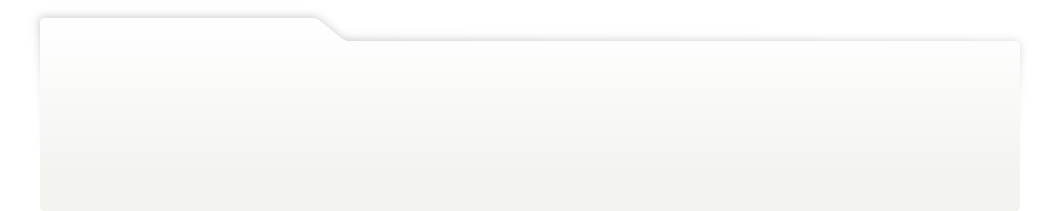
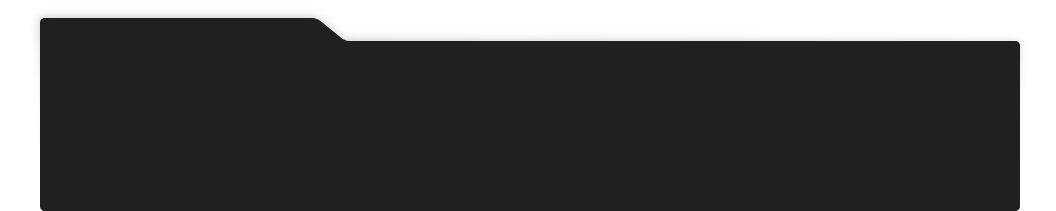
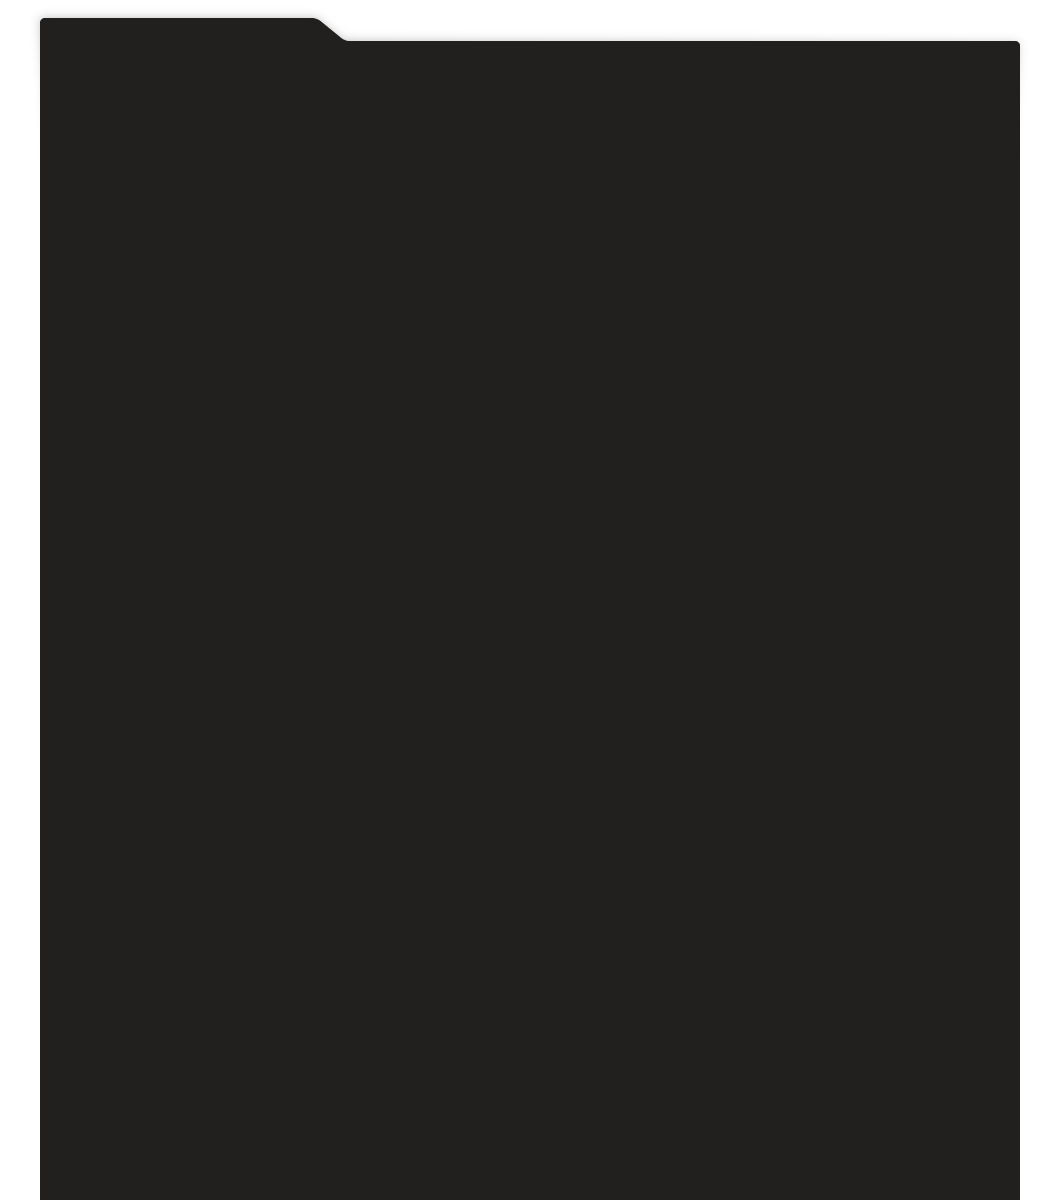
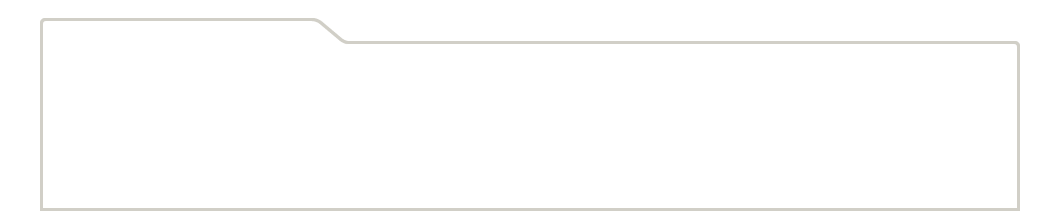
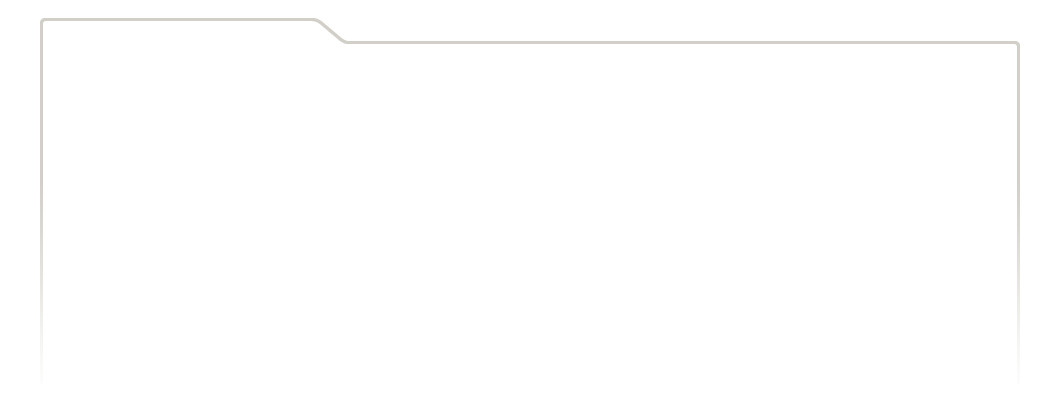
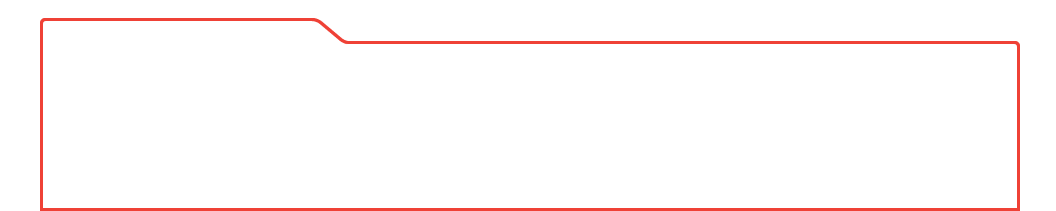
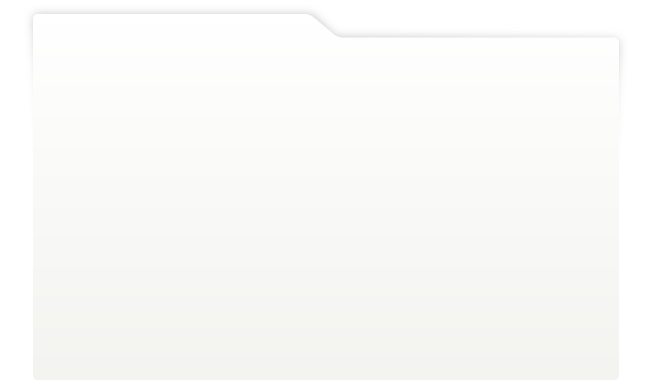
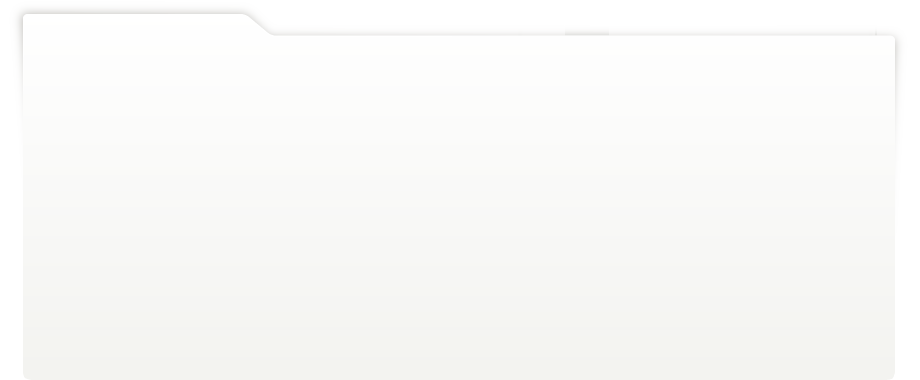
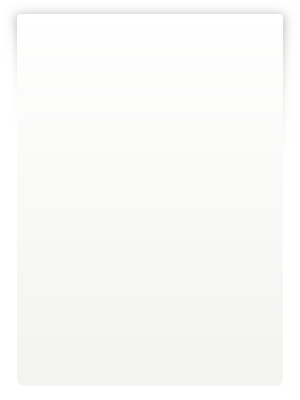
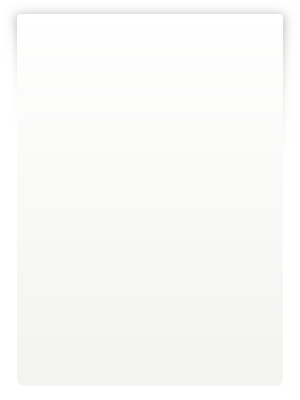
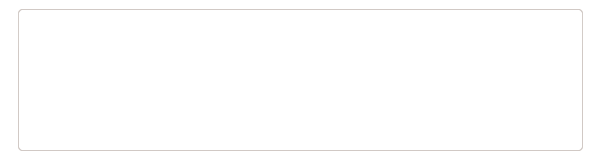
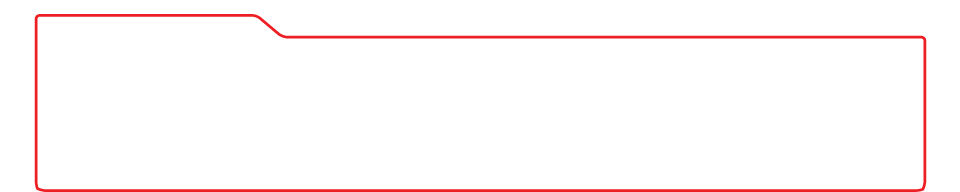
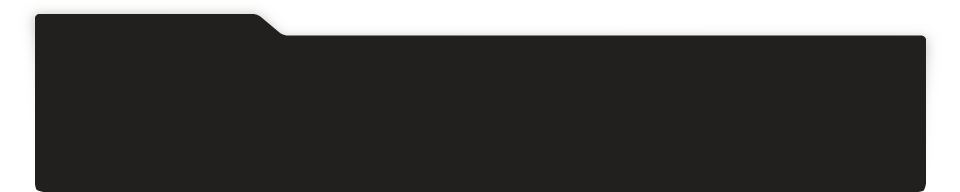
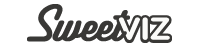
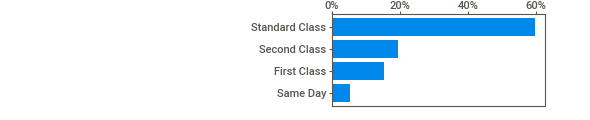
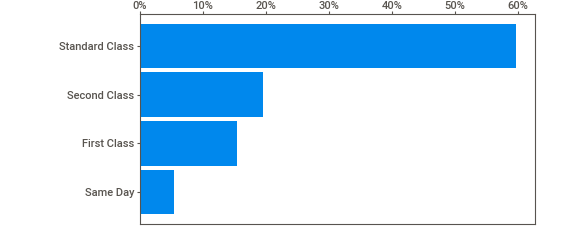
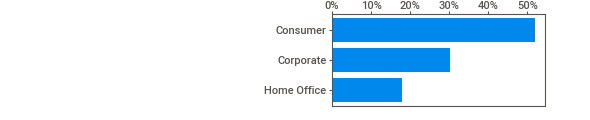
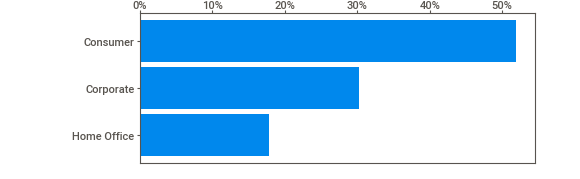
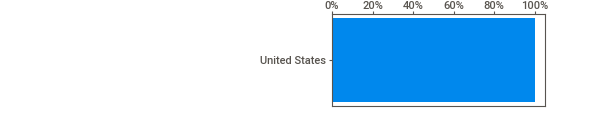
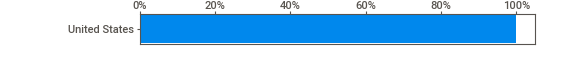
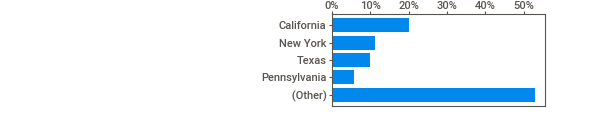
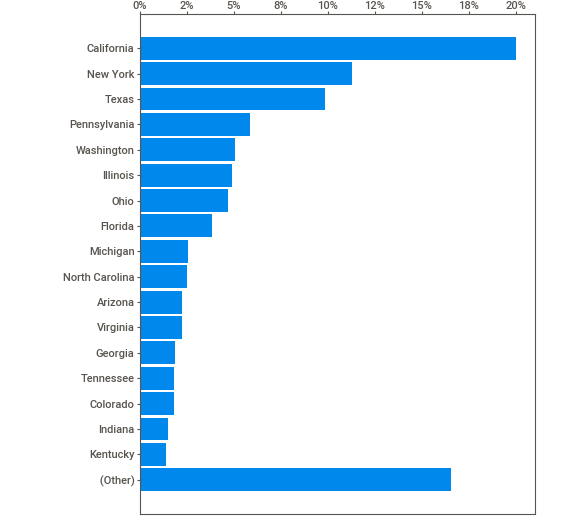
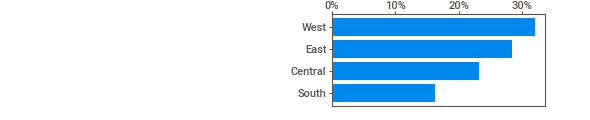
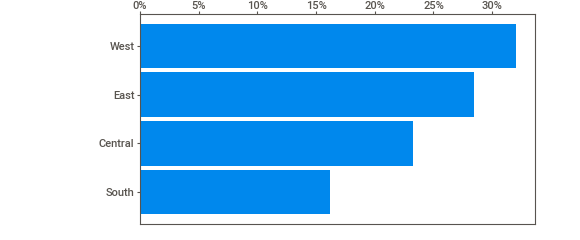
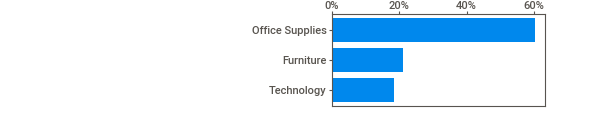
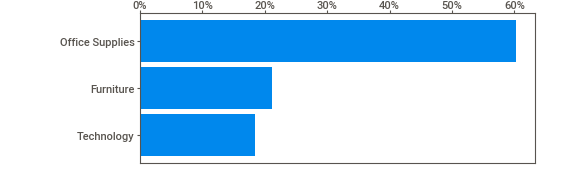
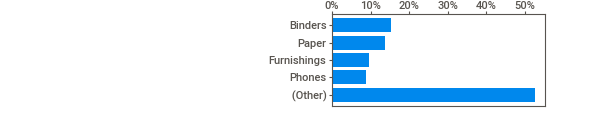
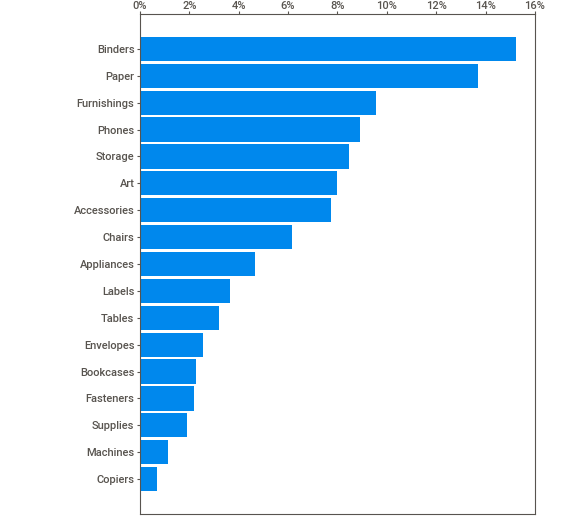
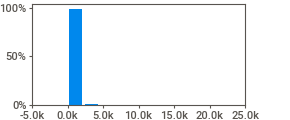
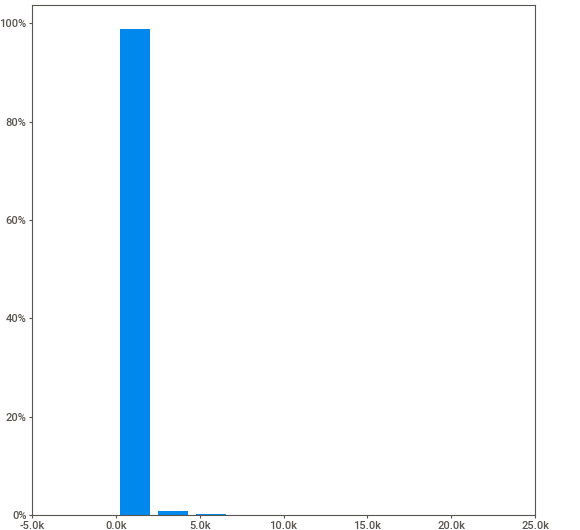
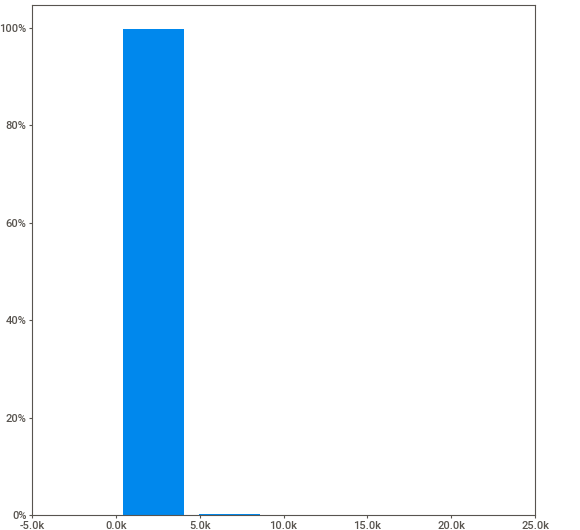
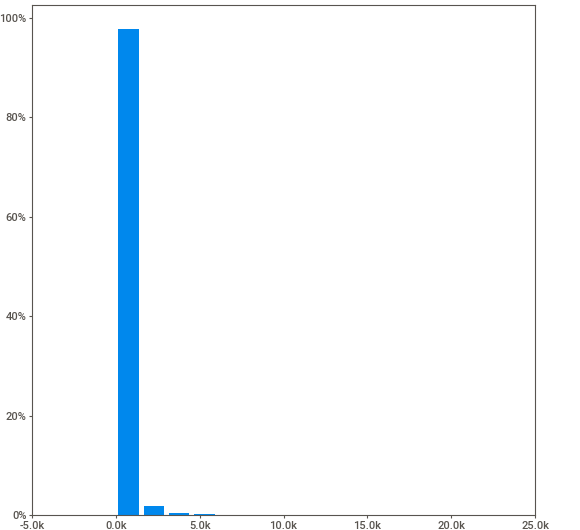
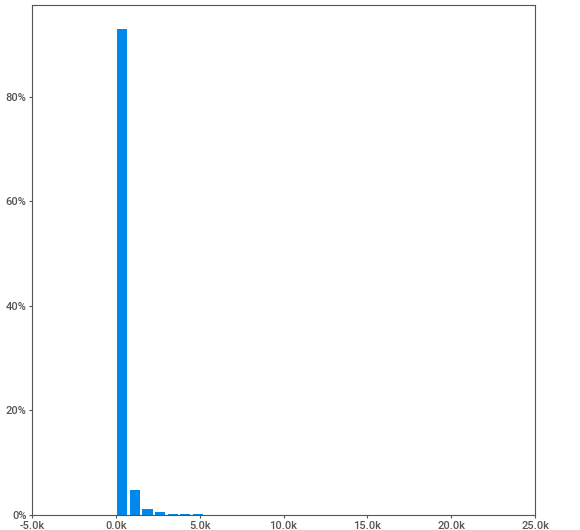
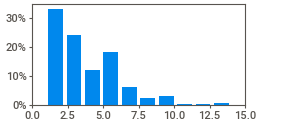
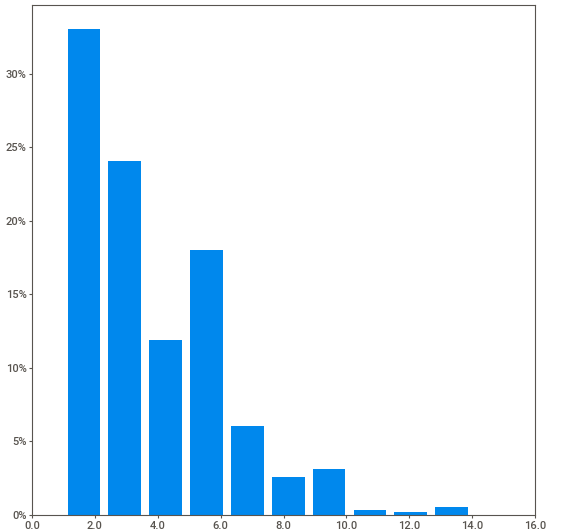
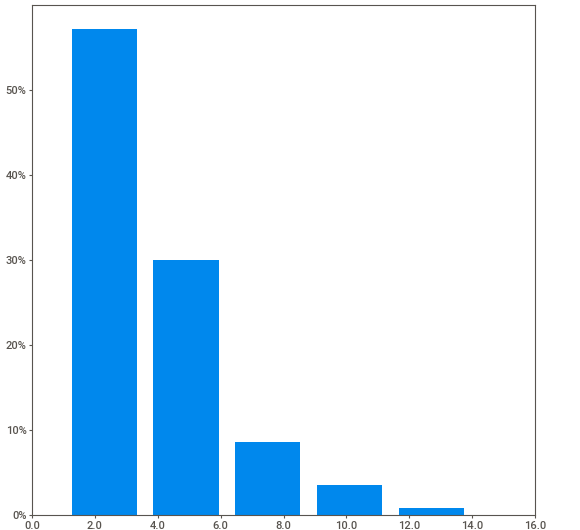
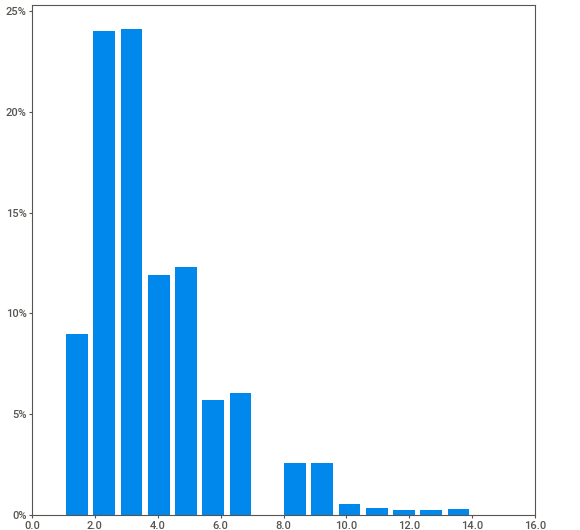
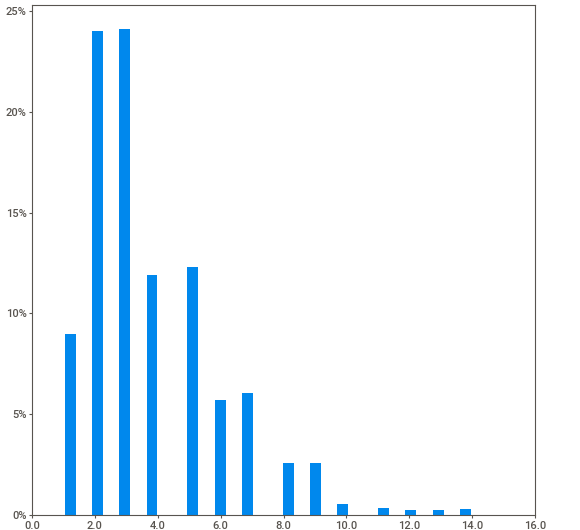
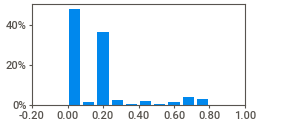
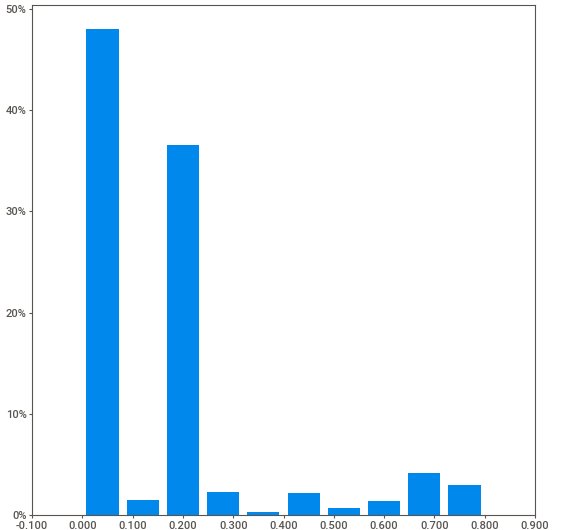
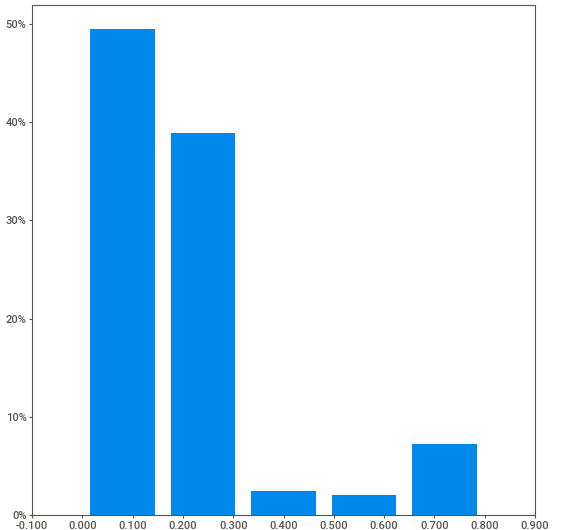
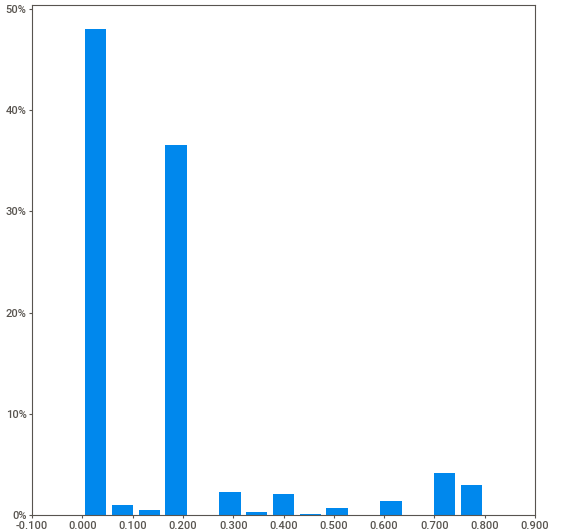
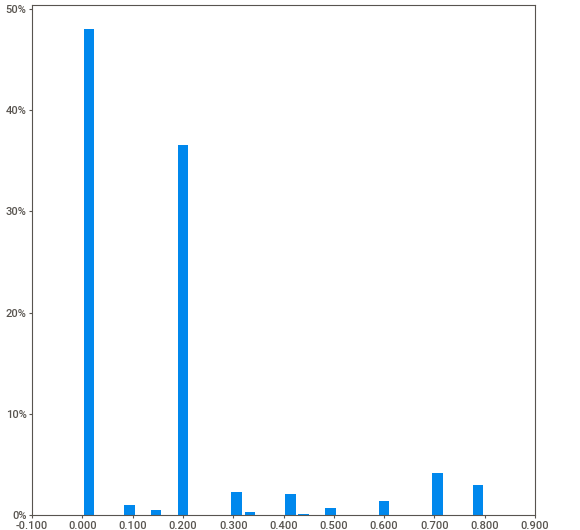
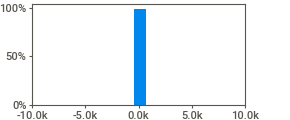
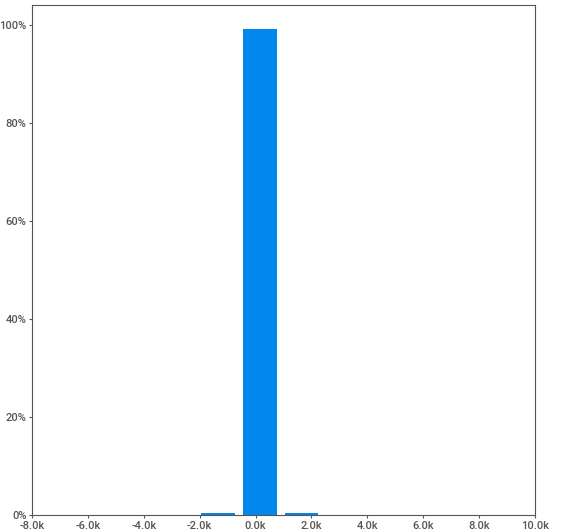
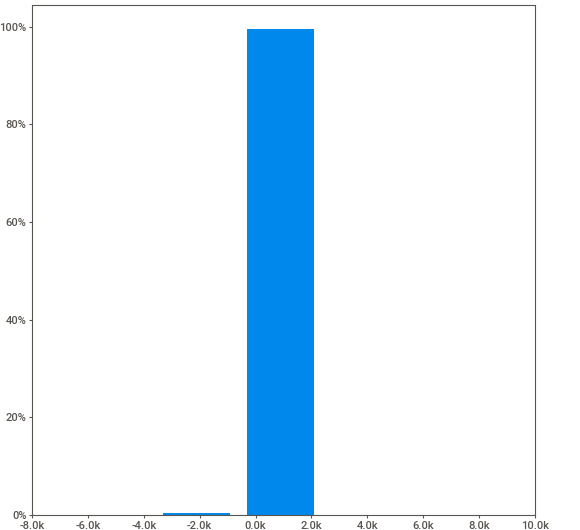
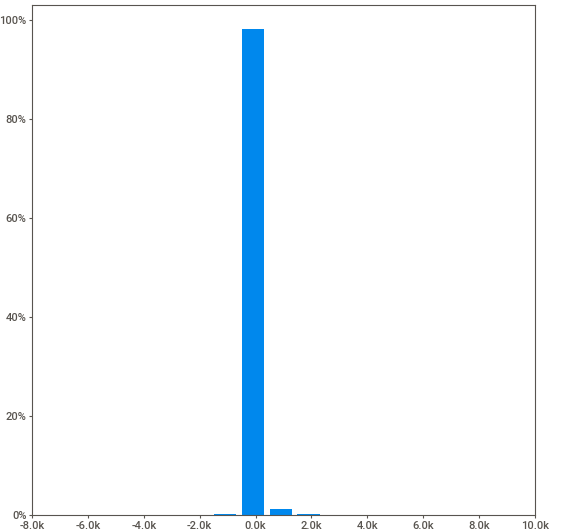
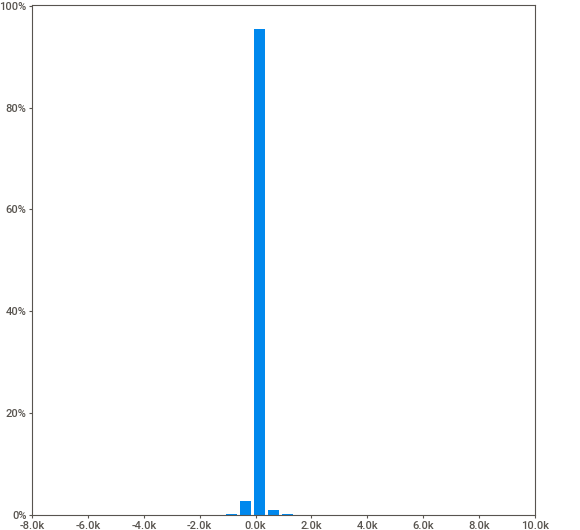
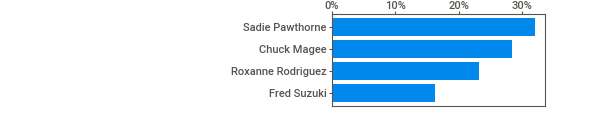
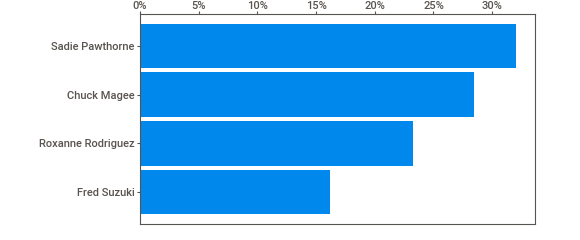
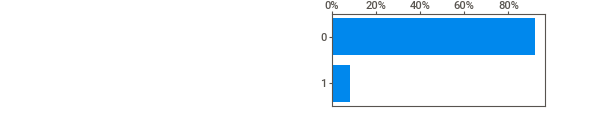
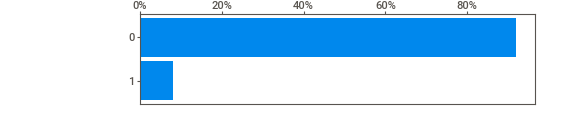
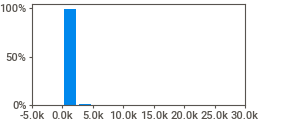
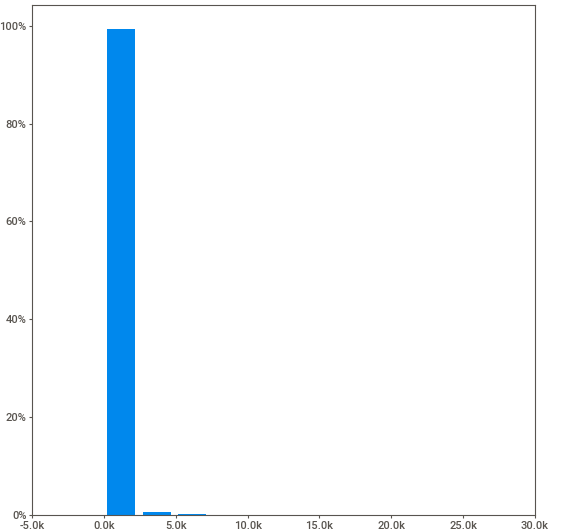
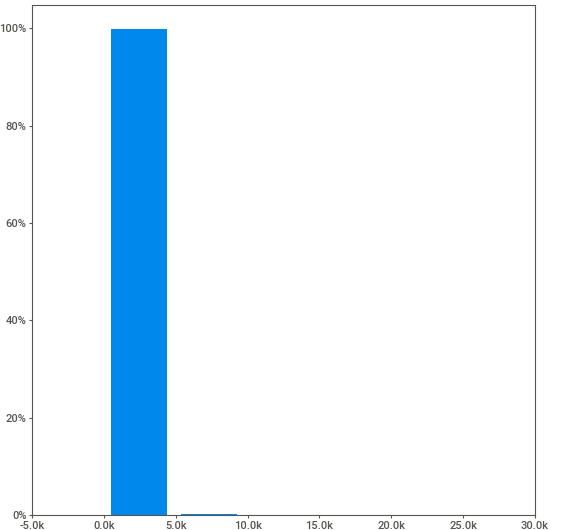
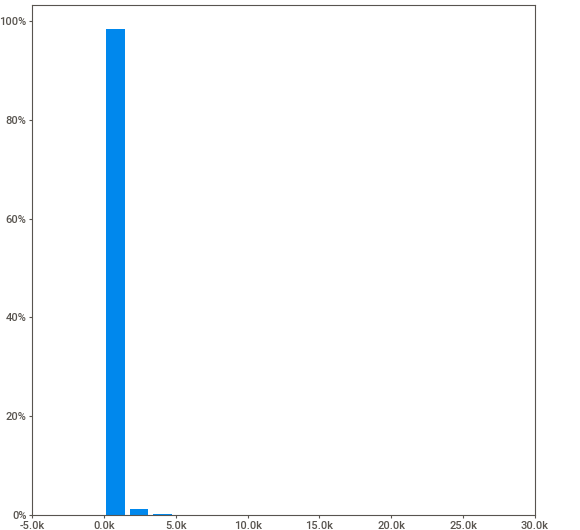
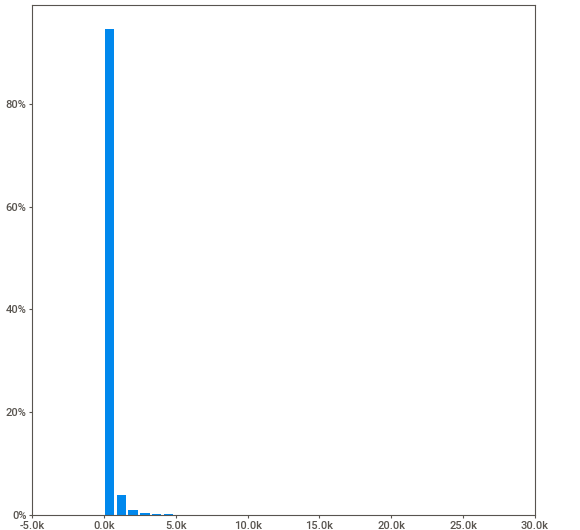
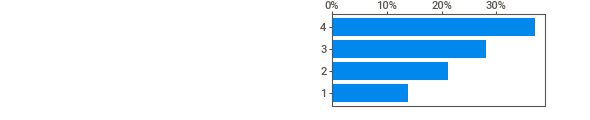
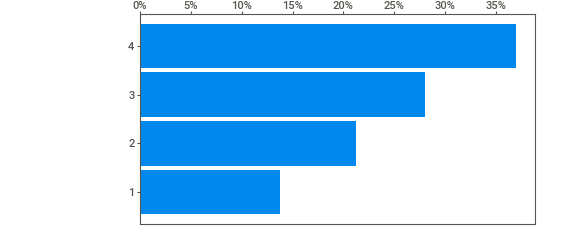
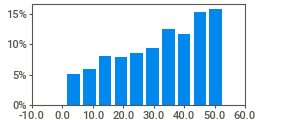
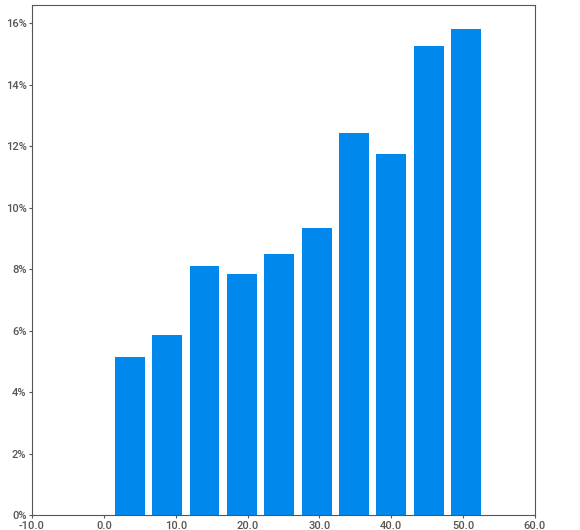
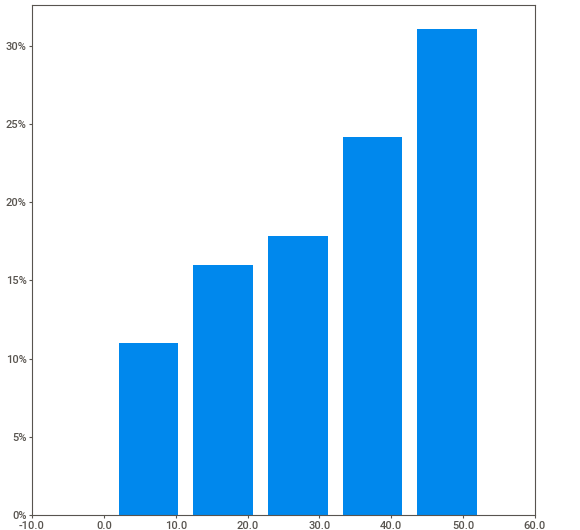
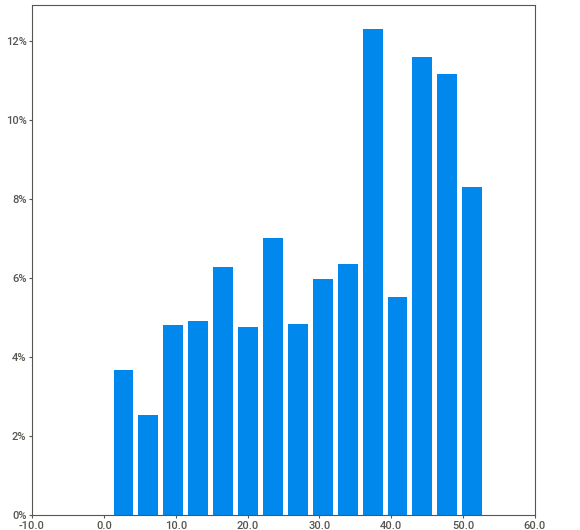
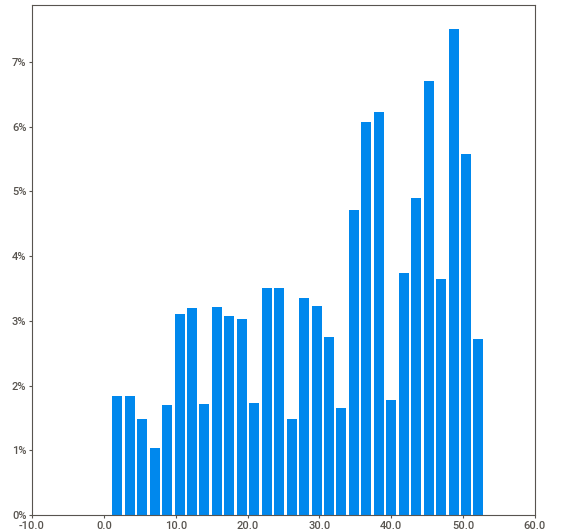
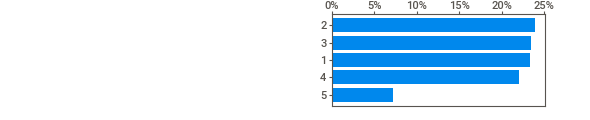
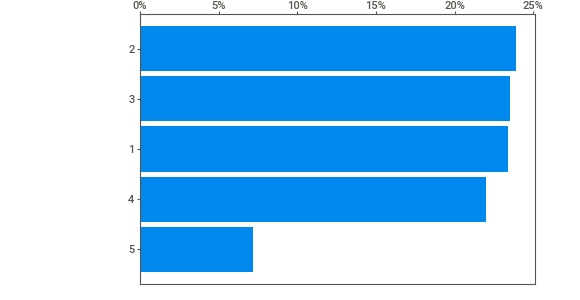
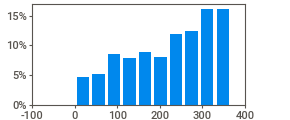
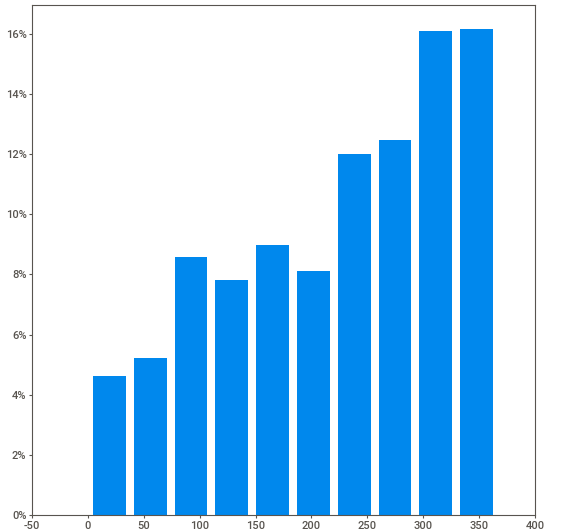
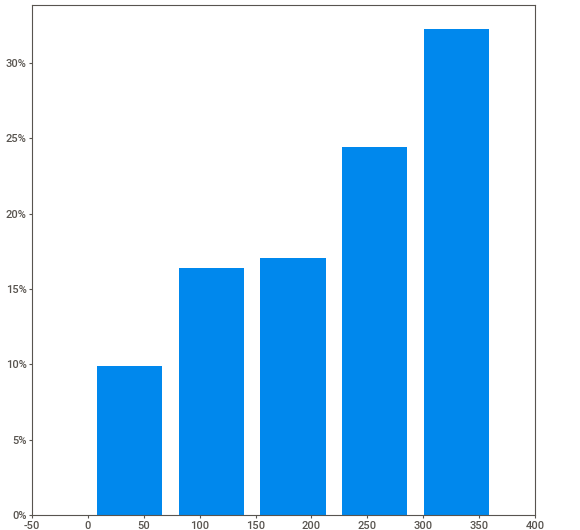
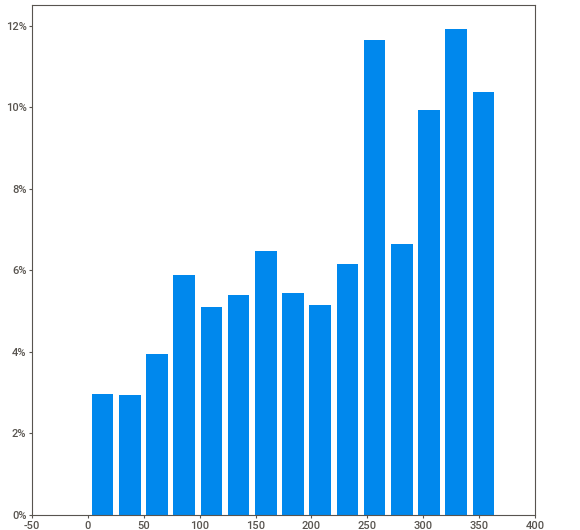
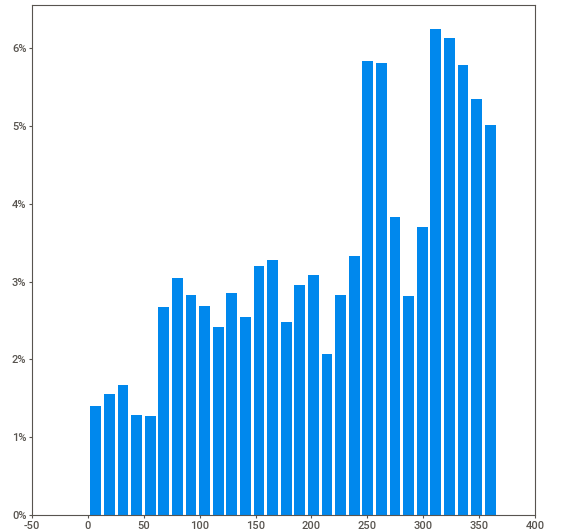
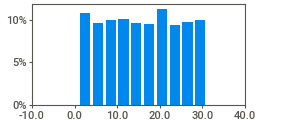
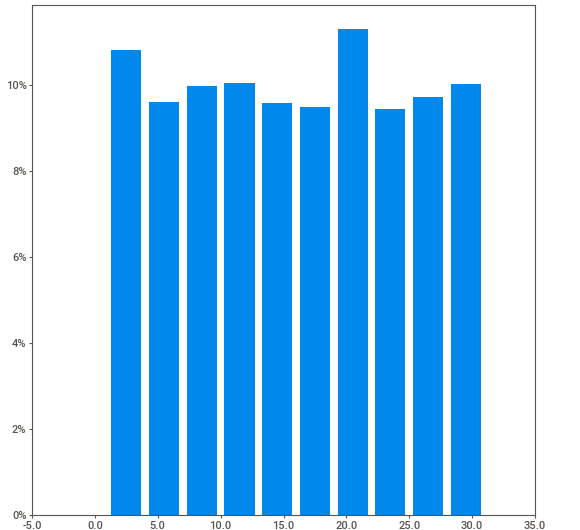
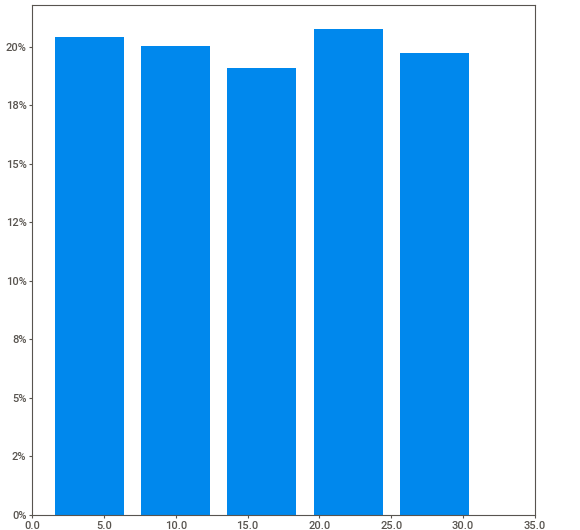
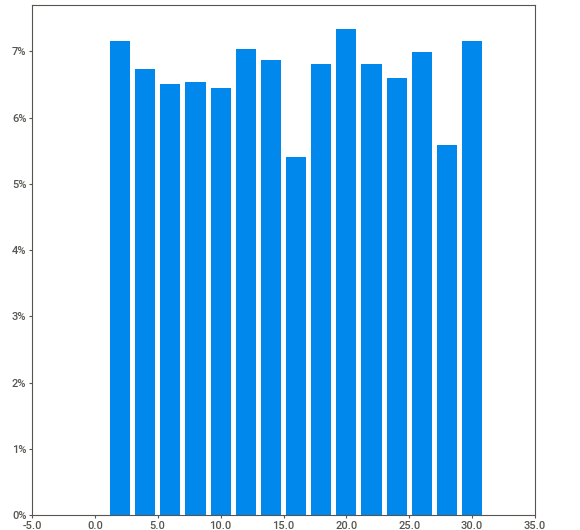
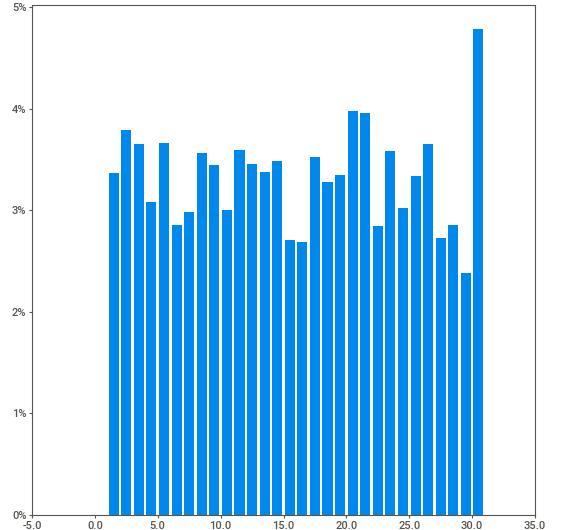
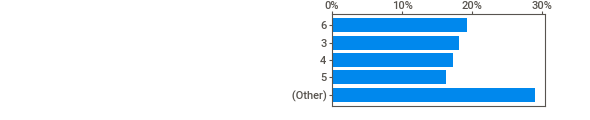
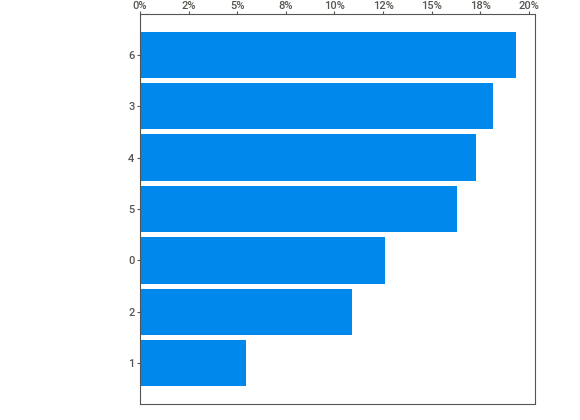
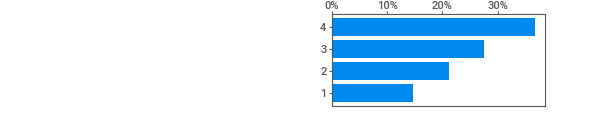
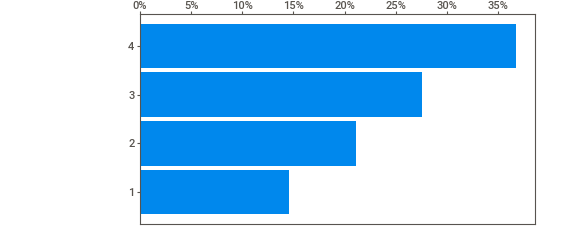
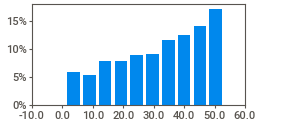
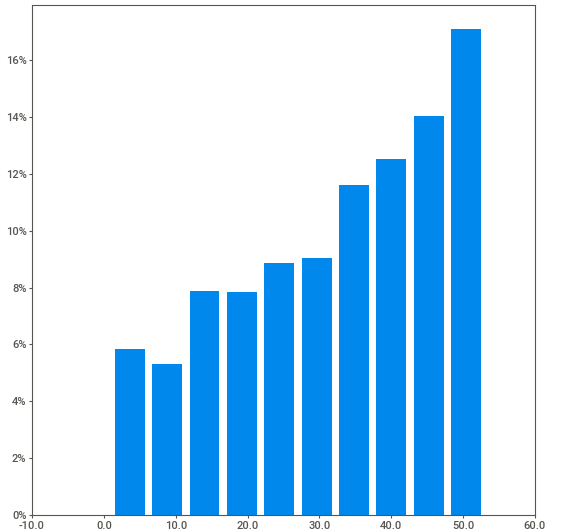
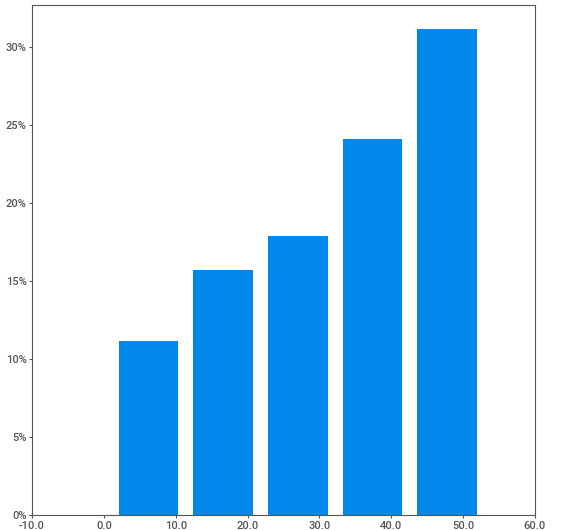
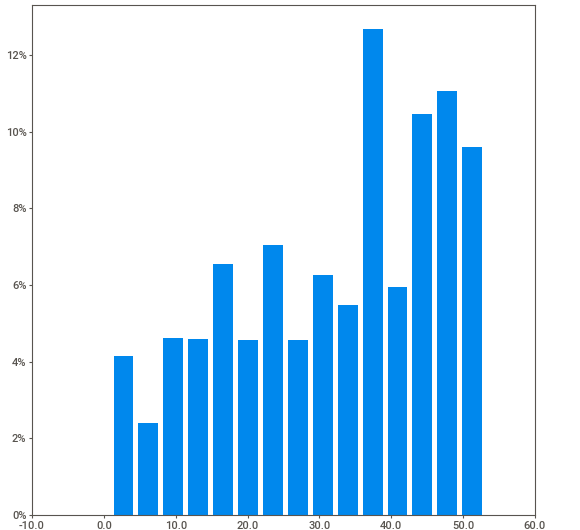
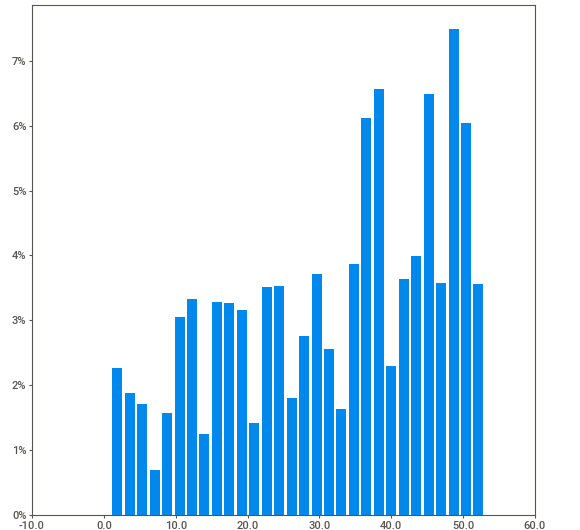
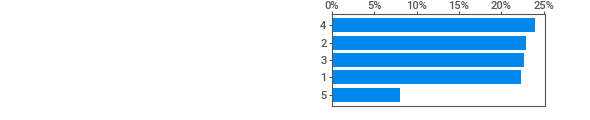
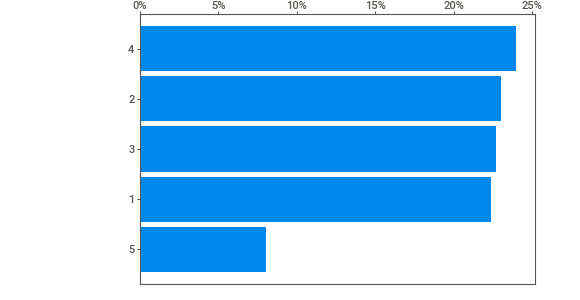
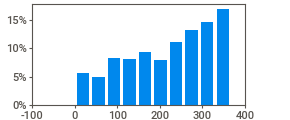
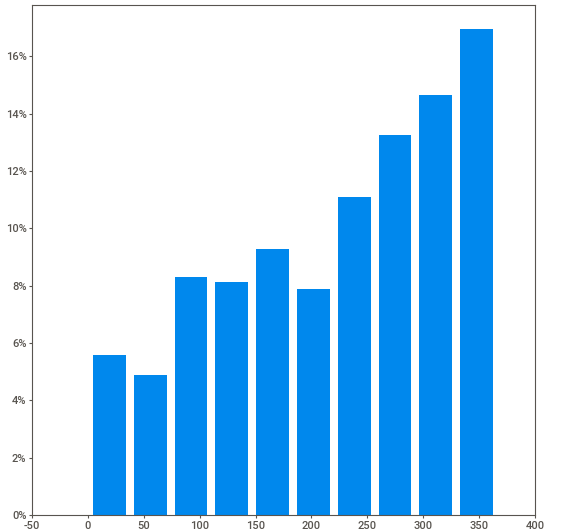
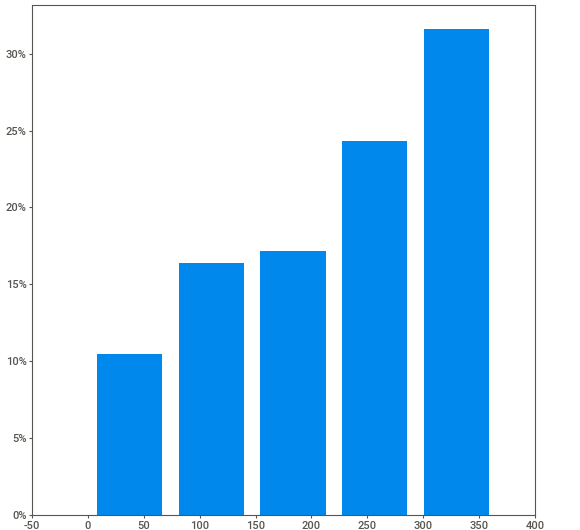
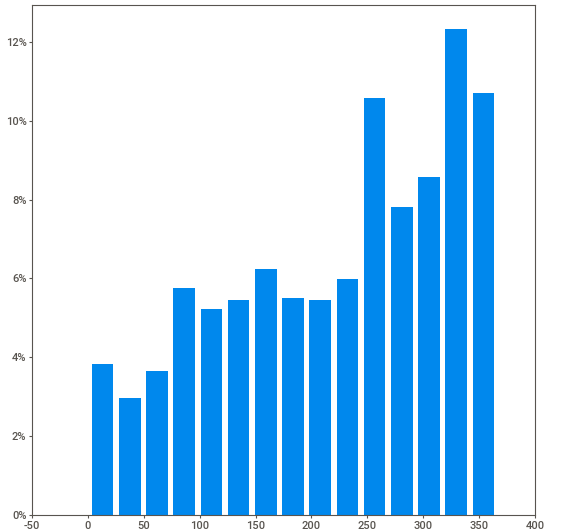
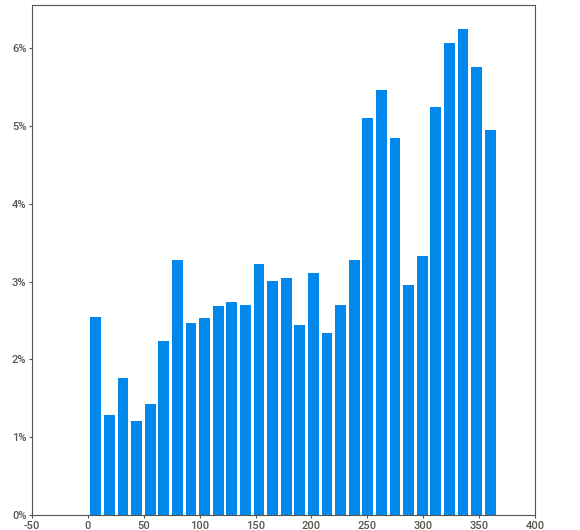
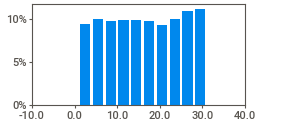
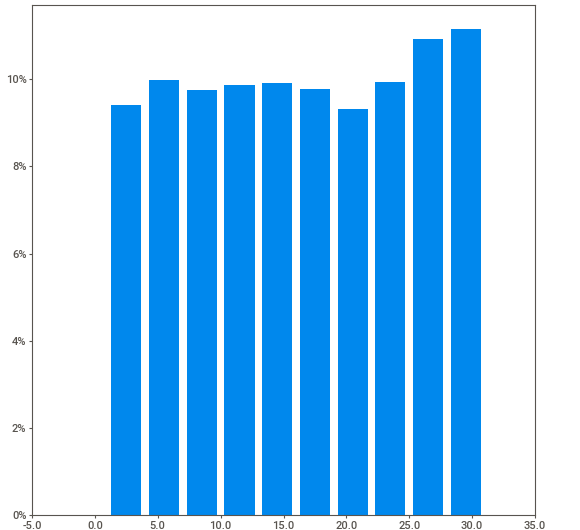
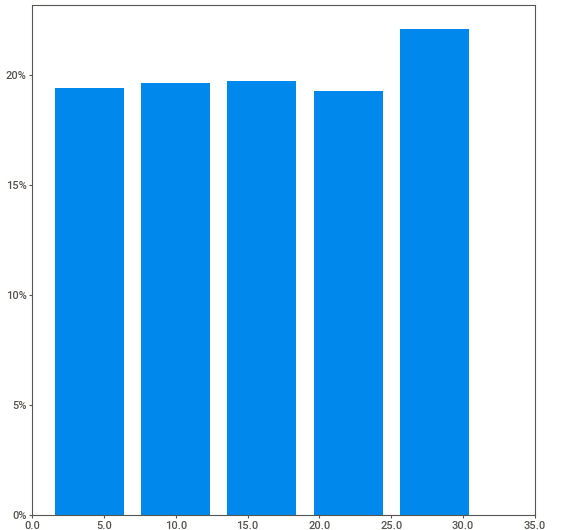
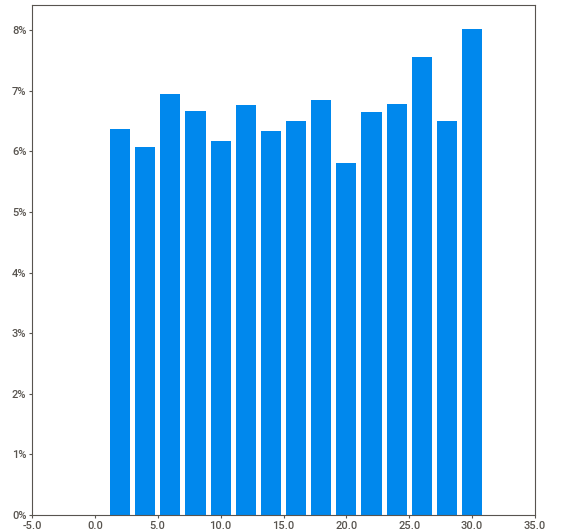
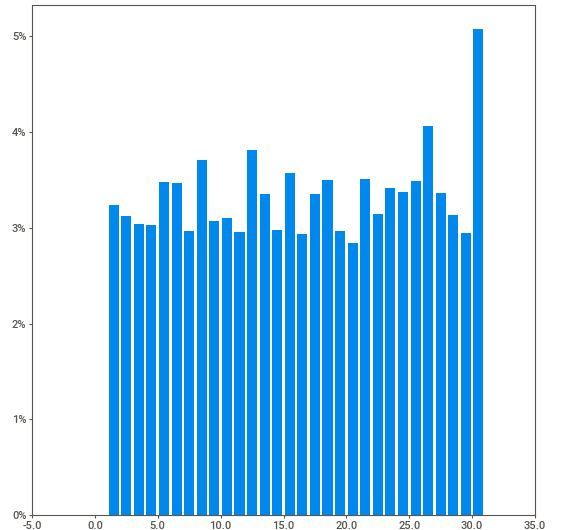
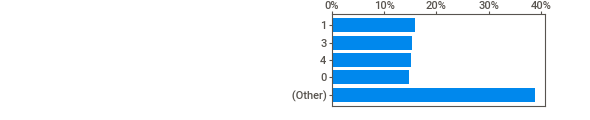
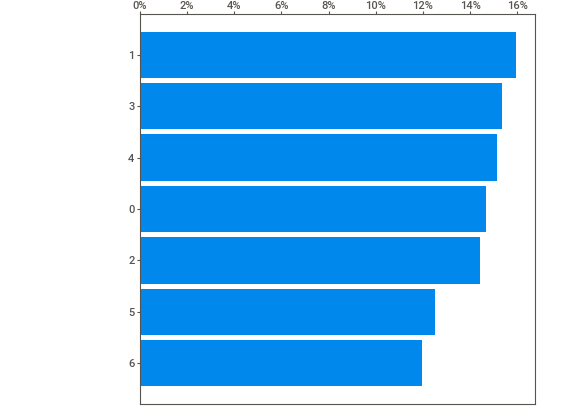
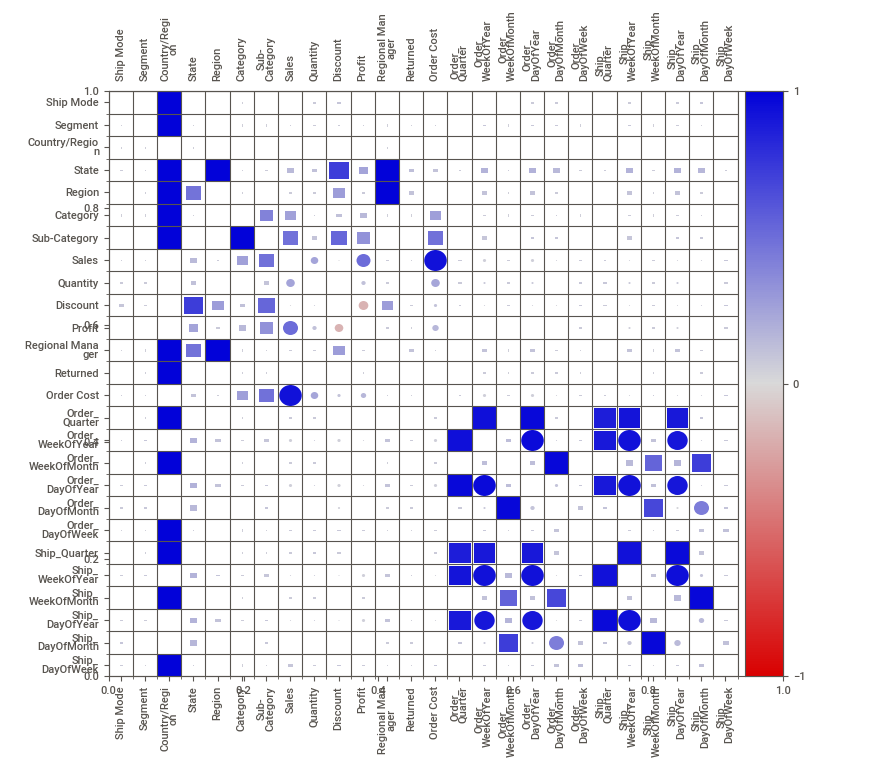
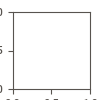

In [22]:
sv.analyze(full_data).show_notebook()

## Save Results

In [24]:
full_data.to_parquet('../data/full_data.parquet', compression = 'zstd')